In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.utils import shuffle
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
%matplotlib inline

In [2]:
# augment functions

# transform x y direction, input original rgb image
def transform_image(image):
    trans_range = 2
    tx = trans_range*(np.random.uniform()-0.5)
    ty = 2*(np.random.uniform()-0.5)
    rows,cols,_ = image.shape
    M = np.float32([[1,0,tx],[0,1,ty]])
    image = cv2.warpAffine(image,M,(cols,rows))
    return image

# Horizontal Flip
def flip_image(image):
    # Horizontal Flip
    image = cv2.flip(image, 1)
    return image

# adjust brightness
def bright_image(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    v = v.astype(np.float)
    v *= (np.random.uniform()+0.2)
    v[v>255] = 255
    v[v<0] = 0
    v = v.astype(np.uint8)
    final_hsv = cv2.merge((h, s, v))
    image_hsv = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return image_hsv

In [3]:
# lesson function
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features/255.0

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 255)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel1_hist[0] /= channel1_hist[0].sum()
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel2_hist[0] /= channel2_hist[0].sum()
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    channel3_hist[0] /= channel3_hist[0].sum()
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



0.200643605812


/home/tzyhpcom/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


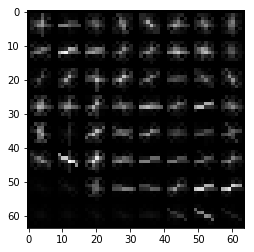

In [4]:
file = '../cars_test/y1.jpg'
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (64, 64))

# Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 36  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
car_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
features, hog_img = get_hog_features(car_hsv[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
print(np.max(features))
plt.figure()
plt.imshow(hog_img, cmap="gray")

In [14]:
file = '../cars_test/y1.jpg'
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (16, 16))
img = image
nbins=32
bins_range=(0, 255)
# Compute the histogram of the color channels separately
channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
channel1_hist = channel1_hist[0].copy()
channel1_hist = np.divide(channel1_hist, channel1_hist.sum())
channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
channel2_hist = channel2_hist[0].copy()
channel2_hist = np.divide(channel2_hist, channel2_hist.sum())
channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
channel3_hist = channel3_hist[0].copy()
channel3_hist = np.divide(channel3_hist, channel3_hist.sum())
# Concatenate the histograms into a single feature vector
hist_features = np.concatenate((channel1_hist, channel2_hist, channel3_hist))

In [15]:
print(channel1_hist.sum())

1.0
